In [53]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [54]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (512,512))
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

In [55]:
def median(citra, kernel_size):
    pad_size = kernel_size // 2
    padded = np.pad(citra, pad_width=pad_size, mode='edge')

    height, width = citra.shape
    result = np.zeros_like(citra)

    for i in range(height):
        for j in range(width):
            area_konvo = padded[i:i+kernel_size, j:j+kernel_size]
            list_konvo = [area_konvo[x][y] for x in range(kernel_size) for y in range(kernel_size)]
            urutkan = np.sort(list_konvo)
            mid = len(urutkan) // 2
            result[i, j] = urutkan[mid]
    return result

In [56]:
def ekualisasi(citra):
    height, width = citra.shape

    hist = np.zeros(256, dtype=int)
    for i in range(height):
        for j in range(width):
            value = citra[i, j]
            hist[value] += 1

    cdf = np.zeros(256, dtype=int)
    for i in range(256):
        cdf[i] = np.sum(hist[:i+1])

    cdf_min = np.min(cdf[cdf > 0])

    norm_cdf = np.round((cdf - cdf_min) / (height * width - cdf_min) * 255)
    norm_cdf = np.minimum(norm_cdf, 255)
    norm_cdf = np.maximum(norm_cdf, 0).astype(np.uint8) 

    citra_eq = np.zeros_like(citra, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            value = citra[i, j]
            citra_eq[i, j] = norm_cdf[value]

    return citra_eq

In [57]:
def perbaikan_citra(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

kernel_sharp = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])

In [58]:
def konvolusi(image, kernel):
    img_height, img_width = image.shape
    k_height, k_width = kernel.shape
    pad_h = k_height // 2
    pad_w = k_width // 2

    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    result = np.zeros((img_height, img_width), dtype=np.float64)

    for i in range(img_height):
        for j in range(img_width):
            area_konvo = padded_img[i:i+k_height, j:j+k_width]
            result[i, j] = np.sum(area_konvo * kernel)

    return result

In [59]:
def deteksi_tepi(image, kernelX, kernelY):
    hasilX = konvolusi(image, kernelX)
    hasilY = konvolusi(image, kernelY)

    magnitude = np.sqrt(hasilX**2 + hasilY**2)

    magnitude = cv.convertScaleAbs(magnitude)

    return magnitude


In [60]:
Sx = np.array([[-1, 0, 1], 
               [-2, 0, 2], 
               [-1, 0, 1]])

Sy = np.array([[ 1,  2,  1], 
               [ 0,  0,  0], 
               [-1, -2, -1]])


In [61]:
def gabung_citra(gambar1, gambar2, alpha=0.2, beta=0.8, gamma=0):
    
    img1 = gambar1.astype(np.float32)
    img2 = gambar2.astype(np.float32)

    gabung = alpha * img1 + beta * img2 + gamma

    gabung[gabung > 255] = 255
    gabung[gabung < 0] = 0

    gabung = gabung.astype(np.uint8)

    return gabung

In [ ]:
def prepro3(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img = median(gray, 5)
    img = ekualisasi(img   )
    img_sharp = perbaikan_citra(img, kernel_sharp)
    img_sobel = deteksi_tepi(img_sharp, Sx, Sy)
    combined = gabung_citra(img_sharp, img_sobel)
    norm = cv.normalize(combined, None, 0, 255, cv.NORM_MINMAX)

    return norm

In [63]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i]
    preprocessed_img = prepro3(img)
    dataPreprocessed.append(preprocessed_img)

In [64]:
def rotasi(image, theta_deg):
    theta = np.radians(theta_deg)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    height, width = image.shape
    rotasi_img = np.zeros_like(image)

    cx, cy = width // 2, height // 2

    for i in range(height):
        for j in range(width):
            x_new = j - cx
            y_new = i - cy

            x_orig = x_new * cos_theta + y_new * sin_theta
            y_orig = -x_new * sin_theta + y_new * cos_theta

            x_orig += cx
            y_orig += cy

            if 0 <= x_orig < width and 0 <= y_orig < height:
                rotasi_img[i, j] = image[int(y_orig), int(x_orig)]

    return rotasi_img

def flip_horizontal(image):
    img_flipped = np.zeros_like(image)
    rows, cols =image.shape
    for i in range(rows):
        for j in range(cols):
            img_flipped[i,j]=image[i, cols - 1-j]
    return img_flipped

def flip_vertical(image):
    img_flipped = np.zeros_like(image)
    rows, cols =image.shape
    for i in range(rows):
        for j in range(cols):
            img_flipped[i,j]=image[rows-1-i,j]
    return img_flipped

In [65]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(dataPreprocessed)):
    img = dataPreprocessed[i]
    label = labels[i]
    fname = file_name[i]

    # Data asli
    data_augmented.append(img)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_original")

    # Rotasi 45
    img_rot = rotasi(img, 45)
    data_augmented.append(img_rot)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_rot")
    img_fliph = flip_horizontal(img)
    data_augmented.append(img_fliph)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_fliph")

    # Flip vertical
    img_flipv = flip_vertical(img)
    data_augmented.append(img_flipv)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_flipv")

In [66]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  504
Data setelah augmentasi:  2016


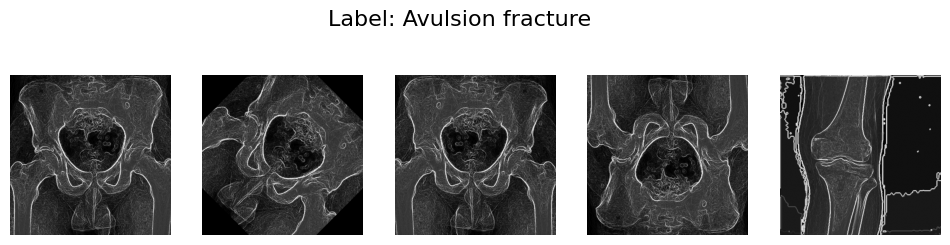

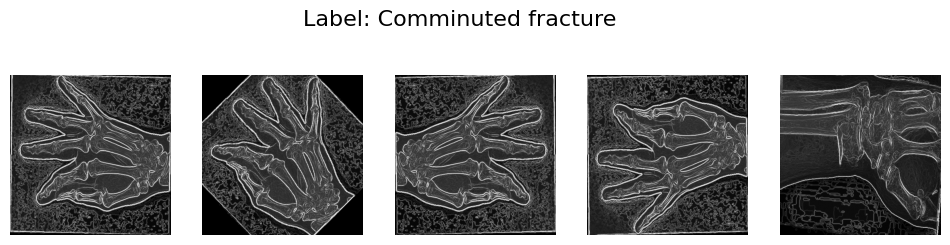

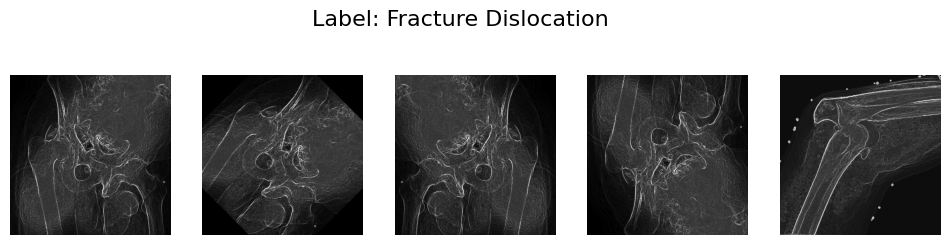

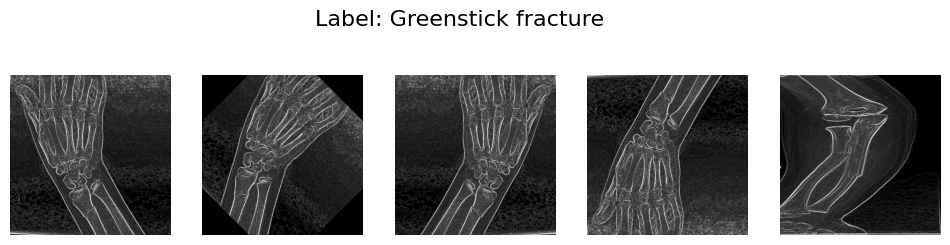

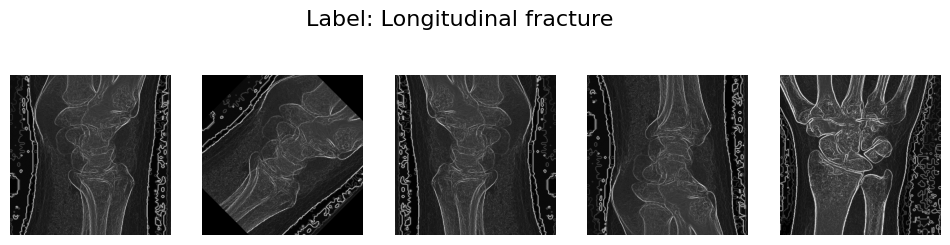

In [67]:
label_dict = {}

for img, label in zip(data_augmented, labels_augmented):
    if label not in label_dict:
        label_dict[label] = []
    if len(label_dict[label]) < 5:
        label_dict[label].append(img)

for label, images in label_dict.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f'Label: {label}', fontsize=16)
    for i, img in enumerate(images):
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

In [68]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [69]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [70]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [71]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [72]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [73]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [74]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [75]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [76]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [77]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [78]:
for i in range(len(data_augmented)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [79]:
for i in range(len(data_augmented)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [80]:
for i in range(len(data_augmented)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [81]:
for i in range(len(data_augmented)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [82]:
for i in range(len(data_augmented)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [83]:
for i in range(len(data_augmented)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [84]:
for i in range(len(data_augmented)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [85]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,626.998146,837.023771,490.434610,862.586314,0.107030,0.091662,0.119455,0.092728,...,0.000300,0.000241,0.016601,0.015461,0.017335,0.015513,0.775550,0.700515,0.824503,0.691369
1,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,575.833789,760.728566,565.246491,631.983617,0.308765,0.238927,0.308336,0.243375,...,0.028797,0.028462,0.169719,0.168547,0.169697,0.168706,0.824022,0.767519,0.827284,0.806864
2,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,626.998146,862.586314,490.434610,837.023771,0.107030,0.092728,0.119455,0.091662,...,0.000300,0.000239,0.016601,0.015513,0.017335,0.015461,0.775550,0.691369,0.824503,0.700515
3,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,626.998146,862.586314,490.434610,837.023771,0.107030,0.092728,0.119455,0.091662,...,0.000300,0.000239,0.016601,0.015513,0.017335,0.015461,0.775550,0.691369,0.824503,0.700515
4,05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c1...,Avulsion fracture,1054.469771,1344.240980,522.075094,1228.262085,0.518312,0.496580,0.567009,0.500794,...,0.087796,0.086108,0.294012,0.293264,0.296304,0.293441,0.786603,0.728100,0.894388,0.751559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,The20fracture20and20Comparison20view20Emergenc...,Longitudinal fracture,143.130703,398.930745,337.359348,418.862435,0.208934,0.166919,0.203242,0.176450,...,0.000710,0.000621,0.027138,0.024275,0.026636,0.024913,0.935032,0.819024,0.847011,0.809982
2012,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,82.726780,382.008391,355.440267,375.420380,0.241926,0.135325,0.147443,0.133203,...,0.000386,0.000356,0.026069,0.018942,0.019648,0.018857,0.948263,0.761357,0.778175,0.765472
2013,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,237.922173,102.005752,234.773338,382.669896,0.356663,0.343003,0.358688,0.271012,...,0.028838,0.028383,0.169795,0.168987,0.169818,0.168472,0.871172,0.944723,0.872863,0.792630
2014,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,82.726780,375.420380,355.440267,382.008391,0.241926,0.133203,0.147443,0.135325,...,0.000386,0.000359,0.026069,0.018857,0.019648,0.018942,0.948263,0.765472,0.778175,0.761357


<Axes: >

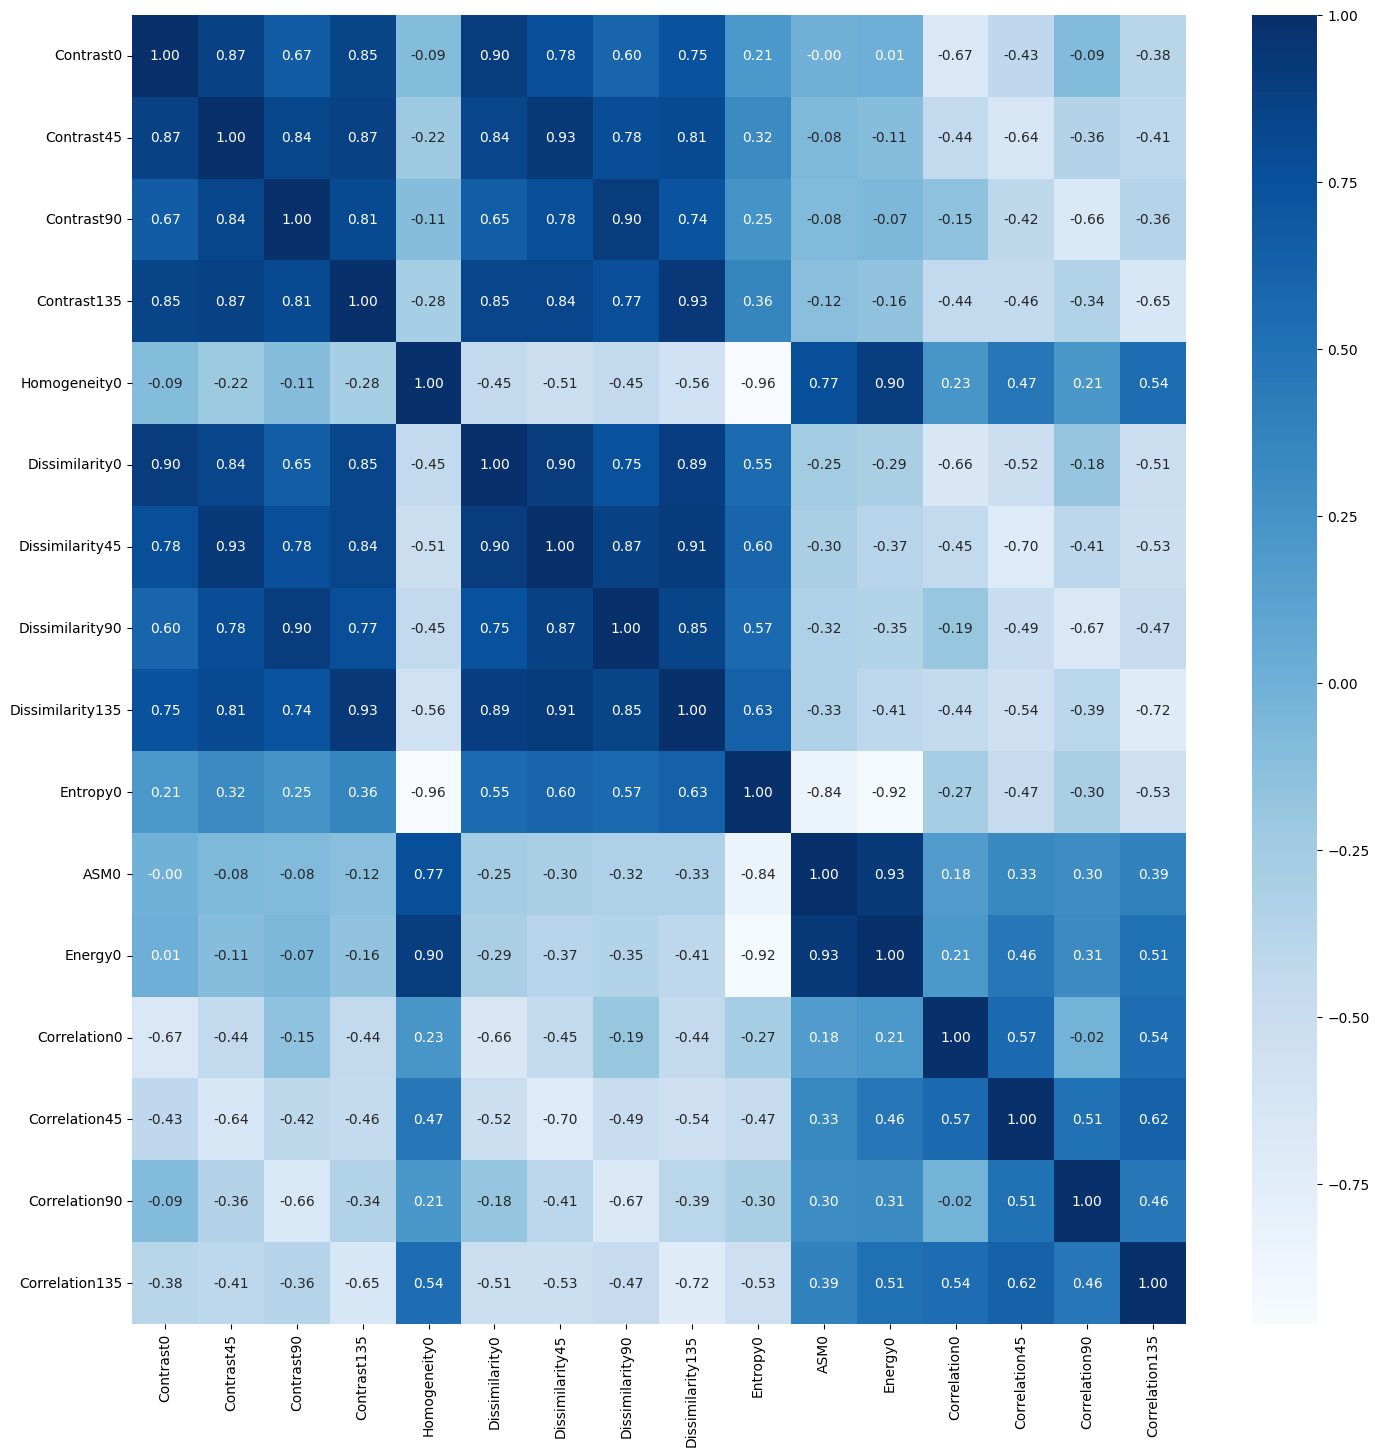

In [86]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [87]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1612, 16)
(404, 16)


In [88]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [89]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [90]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.94      0.99      0.97       293
  Comminuted fracture       0.96      0.99      0.97       385
 Fracture Dislocation       0.99      0.96      0.97       366
  Greenstick fracture       0.98      0.95      0.97       331
Longitudinal fracture       0.97      0.96      0.97       237

             accuracy                           0.97      1612
            macro avg       0.97      0.97      0.97      1612
         weighted avg       0.97      0.97      0.97      1612

[[291   0   0   2   0]
 [  3 380   0   2   0]
 [  8   5 351   0   2]
 [  4   5   3 315   4]
 [  2   5   1   2 227]]
Accuracy: 0.9702233250620348

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.62      0.80      0.70        79
  Comminuted fracture       0.71      0.75      0.73        87
 Fracture Dislocation       0.79      0.65   

In [91]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.49      0.39      0.44       293
  Comminuted fracture       0.50      0.54      0.52       385
 Fracture Dislocation       0.39      0.71      0.51       366
  Greenstick fracture       0.47      0.26      0.34       331
Longitudinal fracture       0.61      0.27      0.38       237

             accuracy                           0.46      1612
            macro avg       0.49      0.44      0.44      1612
         weighted avg       0.48      0.46      0.44      1612

[[115  47 102  15  14]
 [ 37 209 100  34   5]
 [ 32  38 261  29   6]
 [ 35  66 127  87  16]
 [ 15  61  75  21  65]]
Accuracy: 0.45719602977667495

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.36      0.28      0.31        79
  Comminuted fracture       0.43      0.47      0.45        87
 Fracture Dislocation       0.33      0.56 

In [92]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.62      0.79      0.70       293
  Comminuted fracture       0.70      0.79      0.74       385
 Fracture Dislocation       0.72      0.73      0.73       366
  Greenstick fracture       0.74      0.60      0.66       331
Longitudinal fracture       0.79      0.56      0.66       237

             accuracy                           0.70      1612
            macro avg       0.72      0.69      0.70      1612
         weighted avg       0.71      0.70      0.70      1612

[[232  22  17  13   9]
 [ 35 304  18  20   8]
 [ 39  36 267  12  12]
 [ 41  41  45 198   6]
 [ 27  31  23  23 133]]
Accuracy: 0.7034739454094293

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.42      0.56      0.48        79
  Comminuted fracture       0.41      0.46      0.43        87
 Fracture Dislocation       0.50      0.51  

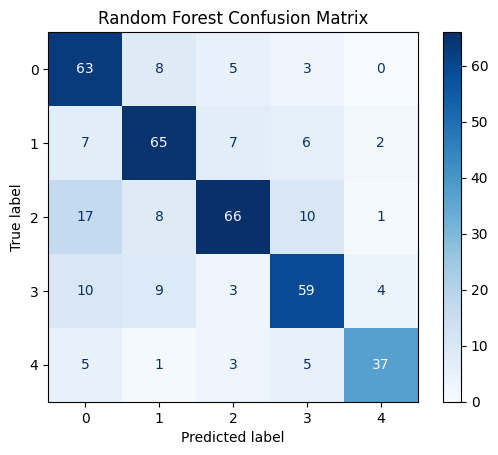

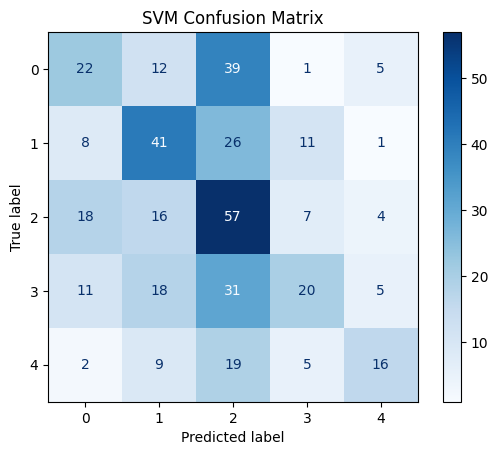

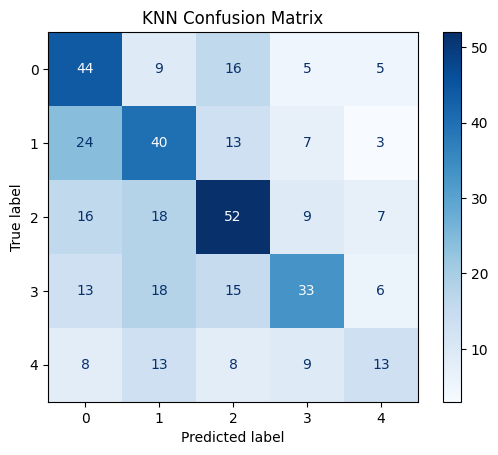

In [93]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")